In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

np.random.seed(0)

In [2]:
df = pd.read_csv('Caravan_Dataset.csv')
df

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,No
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,No
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,No
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,No
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5817,36,1,1,2,8,0,6,1,2,1,...,0,0,0,1,0,0,0,0,0,No
5818,35,1,4,4,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,No
5819,33,1,3,4,8,0,6,0,3,5,...,0,0,0,1,0,0,0,0,0,Yes
5820,34,1,3,2,8,0,7,0,2,7,...,0,0,0,0,0,0,0,0,0,No


In [3]:
y = df['Purchase']
X = df.drop('Purchase',axis=1)


In [4]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
Xscaled = scaler.fit_transform(X)

Create a training set consisting of the first 1,000 observations, and a test set consisting of the remaining observations.

np.random.seed was given 0 at first cell

In [5]:
permutation = np.random.permutation(X.shape[0])
train_set_indexes = permutation[:1000]
test_set_indexes = permutation[1000:]

X_train = Xscaled[train_set_indexes]
X_test = Xscaled[test_set_indexes]
y_train = y[train_set_indexes]
y_test = y[test_set_indexes]

In [6]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((1000, 85), (1000,), (4822, 85), (4822,))

# AUC

There are so many features, instead of making gridsearch for each combination, I have speficied my step size 4 , So I look for number of features 0,4,8,...84.

In [7]:
clf=RandomForestClassifier(random_state=0)
# number of trees in random forest
n_estimators = [100,200,300,400,500,600]
# number of features at every split
max_features = [i for i in range(0,len(X.columns),4)]
# create grid
params = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 }
params

{'n_estimators': [100, 200, 300, 400, 500, 600],
 'max_features': [0,
  4,
  8,
  12,
  16,
  20,
  24,
  28,
  32,
  36,
  40,
  44,
  48,
  52,
  56,
  60,
  64,
  68,
  72,
  76,
  80,
  84]}

In [8]:
# Grid search of parameters
clf_grid = GridSearchCV(estimator = clf, param_grid = params, 
                                cv = 5, verbose=2, scoring='roc_auc',n_jobs = -1)
# Fit the model
clf_grid.fit(X_train, y_train)
# print results
print(clf_grid.best_params_)

Fitting 5 folds for each of 132 candidates, totalling 660 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 660 out of 660 | elapsed:  9.0min finished


{'max_features': 8, 'n_estimators': 200}


# Accuracy on 0.5 standart random forest 

In [48]:
clf=RandomForestClassifier(random_state=0,n_estimators=200,max_features=8,oob_score=True)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print('Test Accuracy:', accuracy_score(y_test, y_pred))

Test Accuracy: 0.9334301119867275


Accuracy can work on string target, but roc auc ask for numeric values

# Random Forrest Threshold

In [49]:
y_test_numeric = np.where(y_test=='No',0,1)
y_pred_numeric = np.where(y_pred == 'No',0,1)

In [50]:

predicted_proba = clf.predict_proba(X_test)
predicted_proba

array([[0.99      , 0.01      ],
       [0.995     , 0.005     ],
       [0.965     , 0.035     ],
       ...,
       [0.94      , 0.06      ],
       [0.805     , 0.195     ],
       [0.74833333, 0.25166667]])

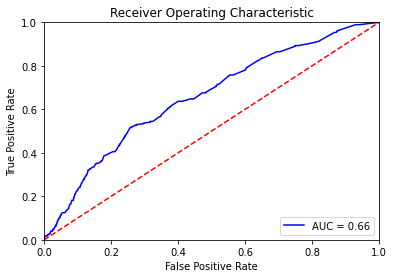

In [51]:
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(y_test_numeric, predicted_proba[:,1])
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



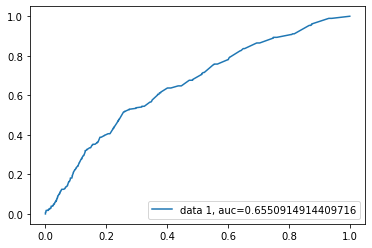

In [63]:
fpr, tpr, _ = metrics.roc_curve(y_test_numeric, predicted_proba[:,1])
auc = metrics.roc_auc_score(y_test_numeric, predicted_proba[:,1])
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [52]:
threshold = 0.2
predicted = (predicted_proba [:,1] >= threshold).astype('int')
predicted

array([0, 0, 0, ..., 0, 0, 1])

# Accuracy on 0.5 Thresholded Random Forest

In [56]:
clf=RandomForestClassifier(random_state=0,n_estimators=200,max_features=8,oob_score=True)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print('Test Accuracy:', accuracy_score(y_test_numeric, y_pred_numeric))

Test Accuracy: 0.9334301119867275


# Accuracy on 0.2 Thresholded Random Forest

In [57]:
print('Test Accuracy:', accuracy_score(y_test_numeric, predicted))

Test Accuracy: 0.8788884280381585


# roc_auc score'In the binary case, you can either provide the probability estimates, using the classifier.predict_proba() method, or the non-thresholded decision values given by the classifier.decision_function() method.' (sklearn documentation)

# Roc Auc score on 0.5 Thresholded

In [58]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test_numeric,y_pred_numeric)

0.5056111929192387

# Roc Auc score on 0.2 Thresholded

In [59]:
roc_auc_score(y_test_numeric,predicted)

0.5434228747019053

# Roc Auc score on Probability ( I have already showed)

In [65]:
metrics.roc_auc_score(y_test_numeric, predicted_proba[:,1])

0.6550914914409716

# Confusion Matrix 0.5 Threshold

In [60]:
cm_normal_threshold = confusion_matrix(y_test_numeric,y_pred_numeric)
cm_normal_threshold

array([[4495,   46],
       [ 275,    6]], dtype=int64)

# Confusion Matrix 0.2 Threshold

In [61]:
cm_our_threshold = confusion_matrix(y_test_numeric,predicted)
cm_our_threshold

array([[4192,  349],
       [ 235,   46]], dtype=int64)

# Verification of y_real values

That can be observed by summing the diagonal values on confusion matrix

In [32]:
sum(y_test == 'No'),sum(y_test == 'Yes'), 

(4541, 281)

# Interpretation

In normal threshold with 0.5. We predict 52 people are going to make purchase. Howeever only 6 of them make purchase. Our accuracy on positive class is 6/52 = 0.115

We also predicted 4770 people are not going to purchase, and 4495 of them actually don't make puchase which was correct, yet 275 of them did. Our accuracy on 'NO' class is 4495/4770 = 0.9423

Total accuracy 0.933 as it is shown in above cells

**************


In 0.2 threshold, We predicted 395 people are going to puchase, and 46 of them did. Accuracy = 46/395 = 0.116

We also predicted 4427 people are not going to do puchase, as it turns out 235 of them did. Rest of them predicted correctly.
Accuracy = 4192/4427 = 0.9469

Total accuracy 0.878 as it is shown in above cells.




# Notice

Especially in unbalanced data rather than accuracy score we are interested in roc-auc score which in this case better in 0.2 threshold value

************************************************

Even though our total accuracy decreased on 0.2 threshold. When we considered class by class, we see that our accuracy for each class increases. Which justifies that our predictions are more reasonable. The reason why our total accuracy reduced is very intuitive. Our dataset is very unbalanced dataset with pretty much consists of 'No' also with 'Yes' class which occurs very rarely. So, observing total accuracy might cause misconception. 

!!!!!!!!!!!!!!!!!
To illustrate, if we have not trained any model and If we have just said all of them are 'No'. In total accuracy, that seems good prediction, but actually it is not. As you have throwed away all of the customers that were going to do puchase

# KNN ( I have selected KNN as you have specified Knn 'or' Logistic)

In [37]:
knn_clf=KNeighborsClassifier()

knn_neighbours = [i for i in range(3,27,2)]

params = {
  'n_neighbors':knn_neighbours
 }

params

{'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]}

In [38]:
# Grid search of parameters
clf_grid = GridSearchCV(estimator = knn_clf, param_grid = params, 
                                cv = 5, verbose=2, scoring='roc_auc',n_jobs = -1)
# Fit the model
clf_grid.fit(X_train, y_train)
# print results
print(clf_grid.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.3s


{'n_neighbors': 5}


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    2.5s finished


In [39]:
knn_clf = KNeighborsClassifier(5)

knn_clf.fit(X_train,y_train)

y_predict = knn_clf.predict(X_test)

accuracy_score(y_test,y_predict)

0.9313562836997097

In [40]:
confusion_matrix(y_test,y_predict)

array([[4483,   58],
       [ 273,    8]], dtype=int64)

KNN results are pretty much similar to random forest with 0.5 threshold. 

In positive class 0.125 accuracy, In negative class 0.9425. 

# What percentage predicted to make do in fact ? 

In KNN 12.5% percentage of customers that are predicted to buy actually buy.
That percentage is  11.6% in 0.2 thresholded random forest
That percentage is 11.5% in 0.5 thresholded random forest



# However ...

However 0.2 thresholded model is bravest one in terms of predicting that customers will buy.  As it can nominate more people to buy it considering meager labels with 'Yes' in test data. So, depending on our purpose we might want to  catch those that are actually buy rather than achieving highest accuracy like the bank credit card example in our lecture

# ! ! !

!!! YOU HAVE NOT MENTION THRESHOLD IN KNN AT HOMEWORK FILE, SO I HAVE NOT DONE ANY THRESHOLD ADJUSTMENT IN KNN